# Machine Learning Layer
#### Goal: Estimate the next beta

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tf as tf
from plotnine import *

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

from tensorflow import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import RootMeanSquaredError

import pickle
import joblib

In [21]:
pd.set_option('display.max_columns', 50)

## 1) Import Data:
CSV file can be found in Teams under Model/ML_for_Beta/all_matrix_data.csv

In [22]:
df = pd.read_csv('../../../../Assets/Data/all_matrix_data_v2.csv', index_col=0)

In [23]:
df.sort_values('beta')

,week,policy_index,variant,mobility,temperature,wind,infections,beta,beta_t_minus_1,start_date_forecasting,district
8,10,57.780000,Other,-6.714286,15.714286,8.885714,2.612245,1.163288e-20,4.148551e-01,2020-05-25,Rhein-Sieg-Kreis
4,6,65.180000,Other,-22.428571,13.314286,12.971429,4.714286,1.804424e-19,5.192031e-01,2020-04-27,Essen
8,10,57.780000,Other,3.142857,14.414286,11.828571,0.500000,3.255453e-17,7.912745e-01,2020-05-25,Weilheim-Schongau
7,9,61.268571,Other,-35.142857,8.414286,8.942857,0.275510,4.153536e-17,3.123958e-01,2020-05-18,Regen
8,10,57.780000,Other,-0.857143,18.214286,10.700000,0.051020,2.933678e-16,4.739704e-01,2020-05-25,Germersheim
...,...,...,...,...,...,...,...,...,...,...,...
15,17,58.804286,Other,9.285714,13.657143,13.928571,0.744898,3.813979e+00,5.671088e-07,2020-07-13,"Schwerin, Landeshauptstadt"
67,69,73.210000,B.1.617.2,17.000000,17.714286,7.914286,0.663265,4.048371e+00,4.618035e-07,2021-07-12,Regen
14,16,63.390000,Other,-6.000000,19.671429,NaN,1.959184,4.140906e+00,5.866983e-07,2020-07-06,Main-Tauber-Kreis
15,17,58.804286,Other,-4.714286,13.414286,NaN,2.030612,4.151339e+00,5.615580e-07,2020-07-13,"Hof, Kreis"


## 2) Visualize Data:
#### 2.1) Average Infections (training period):

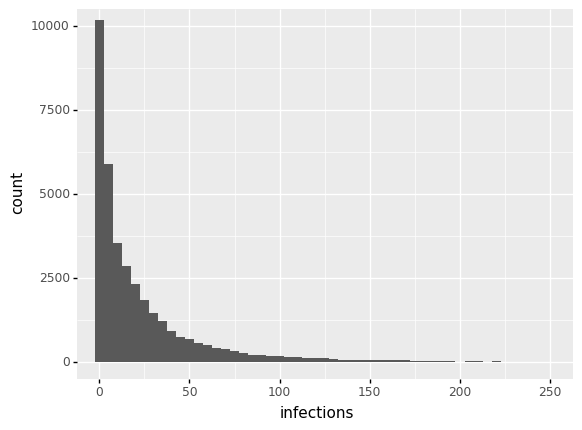

<ggplot: (282818085)>

In [24]:
ggplot(df, aes(x='infections')) + geom_histogram(binwidth=5) + coord_cartesian(xlim=(0,250),ylim=(0,10000))

#### 2.2) Fitted beta:

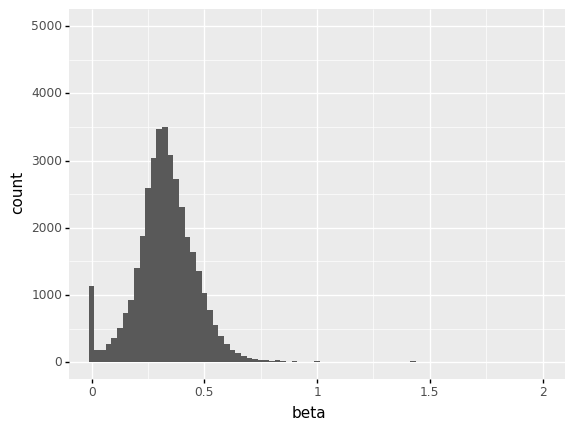

<ggplot: (385717529)>

In [25]:
ggplot(df, aes(x='beta')) + geom_histogram(binwidth=0.025) + coord_cartesian(xlim=(0,2),ylim=(0,5000))

#### 2.3) Average infections Münster

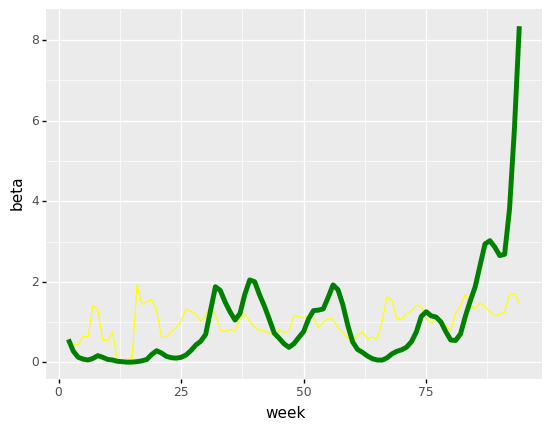

<ggplot: (385833620)>

In [26]:
district = 'Münster'
df_v2_3 = df[df['district']==district][['week','district','infections','beta']]

# Devide both columns by their mean so that they fit in one plot:
df_v2_3['infections'] = df_v2_3['infections']/df_v2_3['infections'].mean()
df_v2_3['beta'] = df_v2_3['beta']/df_v2_3['beta'].mean()

ggplot(df_v2_3) \
+ geom_line(aes(x='week', y='beta'), color='yellow')\
+ geom_line(aes(x='week', y='infections'), color='green', size=2)

#### 2.4) Policy index vs infections: (Germany)

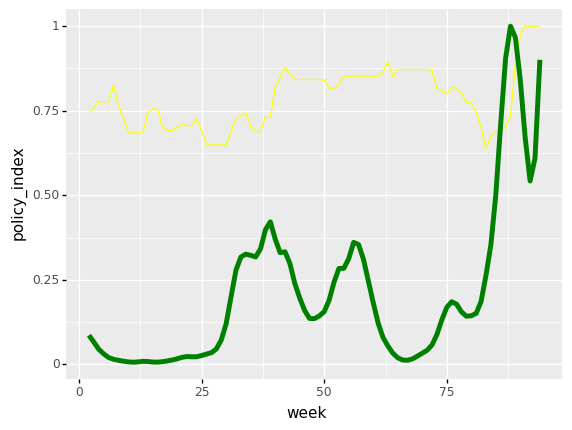

<ggplot: (386236323)>

In [27]:
df_v2_4 = df.groupby('week').sum()

# Devide both columns by their max so that they fit in one plot:
df_v2_4['infections'] = df_v2_4['infections']/df_v2_4['infections'].max()
df_v2_4['policy_index'] = df_v2_4['policy_index']/df_v2_4['policy_index'].max()

ggplot(df_v2_4.reset_index())\
+ geom_line(aes(x='week', y='policy_index'), color='yellow')\
+ geom_line(aes(x='week', y='infections'), color='green', size=2)

## 3) Feature Engineering:
#### Lagged beta: (NO LONGER NECESSARY!)

In [28]:
# Sort values by district and week before lagging:
df.sort_values(['district','week'], inplace=True)

In [29]:
# Check out correlation between current and previous weeks beta:
df['beta'].corr(df['beta_t_minus_1'] )

-0.057764995528538976

## 4) Data cleaning:
#### Identify missing values:

In [30]:
df.isnull().sum()

week                         0
policy_index                 0
variant                      0
mobility                     0
temperature                236
wind                      3739
infections                   0
beta                         0
beta_t_minus_1               0
start_date_forecasting       0
district                     0
dtype: int64

#### Fill missing values with previous column:
Forward fill: Fill down (-> if missing value in week 50 use value of week 49)

In [31]:
df_v4 = df.copy()

In [32]:
df_v4['temperature'] = df.groupby("week").transform(lambda x: x.fillna(x.mean()))['temperature']
df_v4['wind'] = df.groupby("week").transform(lambda x: x.fillna(x.mean()))['wind']

/var/folders/f9/_57rk_kx5jqbkd8vvnwckf2c0000gn/T/ipykernel_71803/1409488165.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
/var/folders/f9/_57rk_kx5jqbkd8vvnwckf2c0000gn/T/ipykernel_71803/1409488165.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.


In [33]:
df_v4

,week,policy_index,variant,mobility,temperature,wind,infections,beta,beta_t_minus_1,start_date_forecasting,district
0,2,62.500000,Other,-41.714286,5.171429,14.975758,52.469388,0.287552,0.339537,2020-03-30,Aachen
1,3,63.778571,Other,-34.428571,5.914286,11.157143,36.877551,0.200627,0.351514,2020-04-06,Aachen
2,4,65.180000,Other,-29.285714,15.071429,10.571429,25.244898,0.222567,0.214686,2020-04-13,Aachen
3,5,65.180000,Other,-32.857143,11.085714,11.071429,16.683673,0.214683,0.210121,2020-04-20,Aachen
4,6,65.180000,Other,-23.714286,13.500000,17.157143,8.091837,0.132383,0.272082,2020-04-27,Aachen
...,...,...,...,...,...,...,...,...,...,...,...
88,90,81.761429,B.1.617.2,-9.714286,1.757143,17.071429,411.897959,0.335567,0.332404,2021-12-06,Zwickau
89,91,83.930000,B.1.617.2,-2.571429,0.428571,8.528571,305.489796,0.315457,0.349078,2021-12-13,Zwickau
90,92,83.930000,B.1.617.2,-1.000000,4.842857,10.485714,203.030612,0.282921,0.346127,2021-12-20,Zwickau
91,93,83.930000,B.1.617.2,-4.285714,-1.200000,10.700000,143.591837,0.321480,0.290336,2021-12-27,Zwickau


## 5) Outlier removal:


In [34]:
# Identify outliers:

In [35]:
df_v4[df_v4['infections'] > 20].sort_values('beta_t_minus_1', ascending=True)

,week,policy_index,variant,mobility,temperature,wind,infections,beta,beta_t_minus_1,start_date_forecasting,district
43,45,70.710000,Other,-0.142857,2.742857,18.042857,38.428571,0.293513,0.115836,2021-01-25,Mansfeld-Südharz
40,42,73.690000,Other,-23.000000,-2.485714,5.785714,21.530612,0.392260,0.136652,2021-01-04,Oberallgäu
38,40,68.790000,B.1.1.7,-30.714286,4.871429,14.228571,48.122449,0.574242,0.141463,2020-12-21,Potsdam
43,45,70.710000,Other,-18.000000,4.814286,14.385714,38.744898,0.219572,0.148054,2021-01-25,Bielefeld
40,42,73.690000,Other,-28.857143,2.228571,11.771429,85.724490,0.403525,0.148255,2021-01-04,Regionalverband Saarbrücken
...,...,...,...,...,...,...,...,...,...,...,...
92,94,83.930000,B.1.1.529,-10.428571,5.571429,20.928571,134.438776,0.424298,0.878277,2022-01-03,Dithmarschen
88,90,81.761429,B.1.617.2,4.000000,2.657143,15.685714,302.653061,0.429999,0.887279,2021-12-06,Börde
12,14,62.370000,Other,-4.714286,17.928571,8.514286,75.244898,0.111004,0.932204,2020-06-22,Gütersloh
29,31,57.865714,Other,21.000000,6.871429,9.347350,22.510204,0.350923,1.036737,2020-10-19,Altenkirchen (Ww)


#### 5.1) Infection counts:
Remove weeks in which the average number of daily infections where below a threshold as for extremely low values it is really hard to forecast beta:

In [36]:
# Drop all rows in which average number of infections is below 5:
threshold = 10
df_v5_1 = df_v4[df_v4['infections'] > threshold]

#### 5.2) Beta values:

In [37]:
# Drop all rows in which the beta value is < 0.025:
threshold = 0.025
df_v5_2 = df_v5_1[df_v5_1['beta'] > threshold]

## 6) Preprocessing columns:
#### 6.1) Handling categorical columns:

In [38]:
# Only use week and district as index columns:
df_v6_1 = df_v5_2.set_index(['week','district','start_date_forecasting'])

In [39]:
# One hot-encode variant columns:
df_v6_2_a = pd.get_dummies(df_v6_1['variant'])
df_v6_2_b = df_v6_1.drop(columns='variant', axis=1)

df_v6_2_c = pd.concat([df_v6_2_a,df_v6_2_b], axis=1)

In [40]:
# Drop "other" variant column to prevent dummy variable trap:
df_v6_2_d = df_v6_2_c.drop(columns='Other', axis=1)

#### 6.2) Standardizing:

In [43]:
# Standardize:
scaler_obj = StandardScaler()

# Split explanatory columns from beta:
explanatory_cols = df_v6_2_d.drop(columns=['beta'], axis=1)
beta_cols = df_v6_2_d[['beta']]

# Apply scaling:
scaled_explanatory_cols = pd.DataFrame(scaler_obj.fit_transform(explanatory_cols), index=explanatory_cols.index, columns=explanatory_cols.columns)

# Merge both together again:
df_v6_3 = pd.concat([scaled_explanatory_cols, beta_cols], axis=1)
df_v6_3

,,,B.1.1.529,B.1.1.7,B.1.617.2,policy_index,mobility,temperature,wind,infections,beta_t_minus_1,beta
week,district,start_date_forecasting,,,,,,,,,,
2,Aachen,2020-03-30,-0.145551,-0.691939,-0.752127,-0.663562,-2.627111,-0.323325,0.948505,-0.011787,-0.358250,0.287552
3,Aachen,2020-04-06,-0.145551,-0.691939,-0.752127,-0.500200,-2.123506,-0.187914,-0.065472,-0.186901,-0.241519,0.200627
4,Aachen,2020-04-13,-0.145551,-0.691939,-0.752127,-0.321142,-1.768020,1.481290,-0.221000,-0.317549,-1.575061,0.222567
5,Aachen,2020-04-20,-0.145551,-0.691939,-0.752127,-0.321142,-2.014885,0.754757,-0.088232,-0.413701,-1.619550,0.214683
25,Aachen,2020-09-07,-0.145551,-0.691939,-0.752127,-1.234323,0.532764,1.499518,-0.319627,-0.476045,-1.554534,0.478947
...,...,...,...,...,...,...,...,...,...,...,...,...
90,Zwickau,2021-12-06,-0.145551,-0.691939,1.329562,1.797445,-0.415198,-0.945695,1.504979,4.025003,-0.427764,0.335567
91,Zwickau,2021-12-13,-0.145551,-0.691939,1.329562,2.074521,0.078532,-1.187873,-0.763450,2.829919,-0.265262,0.315457
92,Zwickau,2021-12-20,-0.145551,-0.691939,1.329562,2.074521,0.187153,-0.383218,-0.243760,1.679186,-0.294017,0.282921


## 7) Modeling
### 7.1) Preparation
#### 7.1.1) Split into train/val:

In [44]:
df_modeling = df_v6_3
df_modeling

,,,B.1.1.529,B.1.1.7,B.1.617.2,policy_index,mobility,temperature,wind,infections,beta_t_minus_1,beta
week,district,start_date_forecasting,,,,,,,,,,
2,Aachen,2020-03-30,-0.145551,-0.691939,-0.752127,-0.663562,-2.627111,-0.323325,0.948505,-0.011787,-0.358250,0.287552
3,Aachen,2020-04-06,-0.145551,-0.691939,-0.752127,-0.500200,-2.123506,-0.187914,-0.065472,-0.186901,-0.241519,0.200627
4,Aachen,2020-04-13,-0.145551,-0.691939,-0.752127,-0.321142,-1.768020,1.481290,-0.221000,-0.317549,-1.575061,0.222567
5,Aachen,2020-04-20,-0.145551,-0.691939,-0.752127,-0.321142,-2.014885,0.754757,-0.088232,-0.413701,-1.619550,0.214683
25,Aachen,2020-09-07,-0.145551,-0.691939,-0.752127,-1.234323,0.532764,1.499518,-0.319627,-0.476045,-1.554534,0.478947
...,...,...,...,...,...,...,...,...,...,...,...,...
90,Zwickau,2021-12-06,-0.145551,-0.691939,1.329562,1.797445,-0.415198,-0.945695,1.504979,4.025003,-0.427764,0.335567
91,Zwickau,2021-12-13,-0.145551,-0.691939,1.329562,2.074521,0.078532,-1.187873,-0.763450,2.829919,-0.265262,0.315457
92,Zwickau,2021-12-20,-0.145551,-0.691939,1.329562,2.074521,0.187153,-0.383218,-0.243760,1.679186,-0.294017,0.282921


#### 7.1.2) Split into train val:

In [45]:
SEED = 420

In [46]:
X_full = df_modeling.drop(columns=['beta'], axis=1)
y_full = df_modeling['beta']

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, shuffle=True, train_size=0.75, random_state=SEED)

### 7.2 Models
#### 7.2.1) Baseline Approach: Choosing previous beta

In [48]:
# Baseline approach would be to use the beta from the previous week for the next week:
## Therefore we have to compare how well this works, compared to our ML approach:

# As the values are standardized we have to reverse standardize them first:
y_pred_baseline_val = pd.DataFrame(scaler_obj.inverse_transform(X_val), index=X_val.index, columns=X_val.columns)['beta_t_minus_1']

In [49]:
# Correlation of this approach:
X_full['beta_t_minus_1'].corr(y_full)

0.3966297511468079

In [50]:
pd.DataFrame({'y_val':y_val, 'y_pred_baseline':y_pred_baseline_val})

,,,y_val,y_pred_baseline
week,district,start_date_forecasting,,
31,Pfaffenhofen a.d.Ilm,2020-10-19,0.461399,0.613393
41,Landkreis Neunkirchen,2020-12-28,0.269198,0.305303
89,Regionalverband Saarbrücken,2021-11-29,0.365568,0.518535
27,Oberbergischer Kreis,2020-09-21,0.287139,0.585525
92,Saalfeld-Rudolstadt,2021-12-20,0.279333,0.299301
...,...,...,...,...
80,Nordsachsen,2021-09-27,0.523480,0.367375
38,"Osnabrück, Stadt",2020-12-07,0.277760,0.315092
88,Hildburghausen,2021-11-22,0.476420,0.405275


In [51]:
# Compute RMSE of baseline approach:
rmse_baseline =  mean_squared_error(y_val, y_pred_baseline_val, squared=False)
print(f'Baseline RMSE is: {rmse_baseline}')

Baseline RMSE is: 0.11121229148715969


#### 7.2.2) Multivariate Linear Regression

In [52]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred_linreg = regr.predict(X_val)
rmse_linreg = mean_squared_error(y_val, y_pred_linreg, squared=False)

In [53]:
print(f'RMSE of {regr} is: {rmse_linreg}. This is an improvement compared to the baseline approach of: {-(rmse_linreg / rmse_baseline -1)*100} %')

RMSE of LinearRegression() is: 0.06810871356705256. This is an improvement compared to the baseline approach of: 38.75792625411712 %


#### 7.2.3) Ridge Regression:

In [54]:
ridge_reg = linear_model.Ridge()
ridge_reg.fit(X_train, y_train)

y_pred_ridge_reg = ridge_reg.predict(X_val)
rmse_ridge_reg = mean_squared_error(y_val, y_pred_ridge_reg, squared=False)

In [55]:
print(f'RMSE of {ridge_reg} is: {rmse_ridge_reg}. This is an improvement compared to the baseline approach of: {-(rmse_ridge_reg / rmse_baseline -1)*100} %')

RMSE of Ridge() is: 0.06810885638018095. This is an improvement compared to the baseline approach of: 38.75779783923916 %


#### 7.2.4) Random Forest Regressor:

In [56]:
rfg_model = RandomForestRegressor()
rfg_model.fit(X_train, y_train)

y_pred_random_forest = rfg_model.predict(X_val)
rmse_random_forest = mean_squared_error(y_val, y_pred_random_forest, squared=False)

In [57]:
print(f'RMSE of {rfg_model} is: {rmse_random_forest}. This is an improvement compared to the baseline approach of: {-(rmse_random_forest / rmse_baseline -1)*100} %')

RMSE of RandomForestRegressor() is: 0.05768252382593405. This is an improvement compared to the baseline approach of: 48.132959896259365 %


#### 7.2.5) Support Vector Machines

In [58]:
svm = SVR()
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_val)
rmse_svm = mean_squared_error(y_val, y_pred_svm, squared=False)

In [59]:
print(f'RMSE of {svm} is: {rmse_svm}. This is an improvement compared to the baseline approach of: {-(rmse_svm / rmse_baseline -1)*100} %')

RMSE of SVR() is: 0.06363144425945627. This is an improvement compared to the baseline approach of: 42.783802573834194 %


#### 7.2.6) XGBoost

In [60]:
xgb_model = xgb.XGBRegressor(verbosity=0)
xgb_model.name = 'XGBoostRegressor'
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_val)
rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False)

In [61]:
print(f'\n RMSE of {xgb_model.name} is: {rmse_xgb}. This is an improvement compared to the baseline approach of: {-(rmse_xgb / rmse_baseline -1)*100} %')


 RMSE of XGBoostRegressor is: 0.05813623633354501. This is an improvement compared to the baseline approach of: 47.724990146204036 %


In [62]:
pd.DataFrame({'beta_opt':y_val, 'last_beta':y_pred_baseline_val, 'last_beta_standardized':X_val['beta_t_minus_1'], 'xgb_bred':y_pred_xgb}).sort_values('start_date_forecasting', ascending=False)

beta_opt  last_beta  \
week district            start_date_forecasting                        
94   Wesel               2022-01-03              0.600204   0.386111   
     Böblingen           2022-01-03              0.513978   0.410184   
     München, Kreis      2022-01-03              0.678642   0.471493   
     Waldeck-Frankenberg 2022-01-03              0.632674   0.273260   
     Düren               2022-01-03              0.604780   0.481528   
...                                                   ...        ...   
2    Unna                2020-03-30              0.330113   0.476911   
     Schwandorf          2020-03-30              0.376181   0.524044   
     Dortmund            2020-03-30              0.359041   0.252210   
     Kelheim             2020-03-30              0.346106   0.513084   
     Erzgebirgskreis     2020-03-30              0.438993   0.378418   

                                                 last_beta_standardized  \
week district            start_date_forecasting                           
94   Wesel               2022-01-03                            0.095672   
     Böblingen           2022-01-03                            0.330291   
     München, Kreis      2022-01-03                            0.927813   
     Waldeck-Frankenberg 2022-01-03                           -1.004190   
     Düren               2022-01-03                            1.025614   
...                                                                 ...   
2    Unna                2020-03-30                            0.980620   
     Schwandorf          2020-03-30                            1.439981   
     Dortmund            2020-03-30                           -1.209345   
     Kelheim             2020-03-30                            1.333168   
     Erzgebirgskreis     2020-03-30                            0.020694   

                                                 xgb_bred  
week district            start_date_forecasting            
94   Wesel               2022-01-03              0.590352  
     Böblingen           2022-01-03              0.560849  
     München, Kreis      2022-01-03              0.548484  
     Waldeck-Frankenberg 2022-01-03              0.540258  
     Düren               2022-01-03              0.553636  
...                                                   ...  
2    Unna                2020-03-30              0.338277  
     Schwandorf          2020-03-30              0.321920  
     Dortmund            2020-03-30              0.341499  
     Kelheim             2020-03-30              0.285526  
     Erzgebirgskreis     2020-03-30              0.290362  

[4809 rows x 4 columns]

#### 7.2.7) Neural Network

In [63]:
ann_model = Sequential([
    Dense(24, input_dim=len(X_train.columns), activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])


# compile model:
ann_model.compile(
    loss = 'mse',
    optimizer = 'adam',
    metrics=[RootMeanSquaredError(name='rmse')]
)

2022-01-27 14:12:06.022886: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [64]:
history = ann_model.fit(X_train,
                        y_train,
                        epochs=20,
                        # class_weight=class_weight,
                        validation_data=(X_val, y_val),
                        )

Epoch 1/20
451/451 [==============================] - 2s 3ms/step - loss: 0.0296 - rmse: 0.1722 - val_loss: 0.0060 - val_rmse: 0.0772
Epoch 2/20
451/451 [==============================] - 1s 3ms/step - loss: 0.0083 - rmse: 0.0912 - val_loss: 0.0051 - val_rmse: 0.0711
Epoch 3/20
451/451 [==============================] - 1s 3ms/step - loss: 0.0061 - rmse: 0.0780 - val_loss: 0.0048 - val_rmse: 0.0694
Epoch 4/20
451/451 [==============================] - 1s 3ms/step - loss: 0.0055 - rmse: 0.0739 - val_loss: 0.0048 - val_rmse: 0.0692
Epoch 5/20
451/451 [==============================] - 1s 3ms/step - loss: 0.0053 - rmse: 0.0726 - val_loss: 0.0047 - val_rmse: 0.0682
Epoch 6/20
451/451 [==============================] - 1s 3ms/step - loss: 0.0052 - rmse: 0.0718 - val_loss: 0.0046 - val_rmse: 0.0680
Epoch 7/20
451/451 [==============================] - 1s 3ms/step - loss: 0.0049 - rmse: 0.0703 - val_loss: 0.0045 - val_rmse: 0.0668
Epoch 8/20
451/451 [==============================] - 1s 3ms/s

In [65]:
y_pred_ann = ann_model.predict(X_val)
rmse_ann = mean_squared_error(y_val, y_pred_ann, squared=False)

In [66]:
print(f'RMSE of {ann_model} is: {rmse_ann}. This is an improvement compared to the baseline approach of: {-(rmse_ann / rmse_baseline -1)*100} %')

RMSE of <keras.engine.sequential.Sequential object at 0x170579280> is: 0.06370530779350221. This is an improvement compared to the baseline approach of: 42.71738587379302 %


## 8) Export Best Model:

In [67]:
path = '../../../../Assets/MachineLearningLayer/Models/'
best_model = xgb_model

# ML Model:
filename = 'xgb_model_lukas.pkl'
combined_path = path+filename
joblib.dump(best_model, open(combined_path, 'wb'))

# Standardizer:
filename = 'standardizer_model.pkl'
combined_path = path+filename
joblib.dump(scaler_obj, open(path+filename, 'wb'))